# Metropolis of 1d XY model 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [2]:
from matplotlib import animation

In [3]:
import copy

In [4]:
class XY_1D:
    def __init__(self, length, delta=0.1, beta=1, j = 1, periodic_cond=True, seed = 0):
        np.random.seed(seed)
        self.length = length
        self.delta = delta
        self.beta = beta
        self.j = j
        self.periodic_cond = periodic_cond
        self.grids_init()
        
    def grids_init(self):      
        self.grids = np.random.uniform(-np.pi, np.pi, self.length)
        
    def energy_compute_one_grid(self, id_grid, theta_grid):
        if self.periodic_cond:
            left_neibor = (id_grid - 1) % self.length
            right_neibor = (id_grid + 1) % self.length
            e_left = -self.j * np.cos(self.grids[left_neibor] - theta_grid)
            e_right = -self.j * np.cos(theta_grid - self.grids[right_neibor])
            energy = e_left + e_right
            return energy
        
        else:
            if id_grid == 0:
                return -self.j * np.cos(theta_grid - self.grids[id_grid+1])
            
            elif id_grid == self.length - 1:
                return -self.j * np.cos(theta_grid - self.grids[id_grid-1])
            
            else:
                e_left = -self.j * np.cos(self.grids[id_grid-1] - theta_grid)
                e_right = -self.j * np.cos(theta_grid - self.grids[id_grid+1])
                energy = e_left + e_right
                return energy
    
    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.length-1):
            energy_i = -self.j * np.cos(self.grids[i] - self.grids[i+1])
            energy_total += energy_i
        return energy_total
    
    def one_step_mcmc(self):
        id_random = np.random.randint(self.length)
        theta_id = self.grids[id_random]
        theta_random = np.random.normal(theta_id, self.delta)
        energy_old = self.energy_compute_one_grid(id_random, theta_id)
        energy_new = self.energy_compute_one_grid(id_random, theta_random)
        energy_delta = energy_new - energy_old
        prob_accept = min(np.exp(-self.beta * energy_delta), 1)
        if np.random.uniform(0, 1) < prob_accept:
            self.grids[id_random] = theta_random
            return energy_new
        else:
            return energy_old
            
    def mcmc(self, step, show_energy=True, show_plot=True, period=100, store_period=100, energy_accumu=False, folder_name=None):
        energy_list, spins_list = [], []
        for i in range(step):
            self.one_step_mcmc()
            energy_total = self.energy_compute_grids()
            energy_list.append(energy_total)
            print_template = "Step: {step} Energy: {energy}\t"
            if show_energy:
                print(print_template.format(step=i+1, energy=energy_total))  
            if show_plot and i % period == 0:
                self.spin_viz(save=True, step=i, folder_name=folder_name)
            if i % store_period == 0:
                spins_list.append(self.grids.copy())
        if energy_accumu:
            return np.mean(energy_list), spins_list
        else:
            return spins_list
        
    def spin_viz_dynamic(self, spins_list, file_name, figsize=(10, 3)):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.length), 0)
        u = np.cos(spins_list[0])
        v = np.sin(spins_list[0])
        q = plt.quiver(x, y, u, v, scale=20, width=0.01, headlength=3, headwidth=2, headaxislength=3, minshaft=3)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.length), fontsize=20)            
        def update_quiver(num, q):
            u = np.cos(spins_list[num+1])
            v = np.sin(spins_list[num+1])
            q.set_UVC(u, v)
            return q
        frames = len(spins_list) - 1
        self.anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                       fargs=(q, ), interval=50, repeat=False)
        writergif = animation.PillowWriter(fps=100) 
        self.anim.save(f'./{file_name}.gif', writer=writergif)
        
    def spin_viz(self, figsize=(10, 3), save=False, step=None, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.length), 0)
        u = np.cos(self.grids)
        v = np.sin(self.grids)
        q = plt.quiver(x, y, u, v, units='width')
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.length), fontsize=10)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

### Test of our model

### Periodic Boundary Condition

In [5]:
# initialize the 1d xy model
length = 20
xy_1d = XY_1D(length, beta=20, j=1, periodic_cond=True)

In [6]:
# firing stage
spins_list = xy_1d.mcmc(3000, show_energy=False, store_period=40, folder_name='firing')
print('mcmc is done!')

mcmc is done!


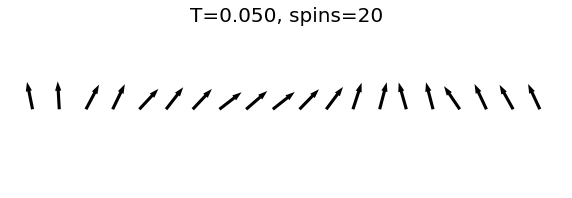

In [7]:
xy_1d.spin_viz_dynamic(spins_list, file_name='./mcmc_dynamics', figsize=[10, 3])

In [8]:
### sampling stage
energy_list = []
for i in trange(200):
    energy_list.append(xy_1d.mcmc(200, show_energy=False, show_plot=False, energy_accumu=True)[0])
print("iterations are done!")

  0%|          | 0/200 [00:00<?, ?it/s]

iterations are done!


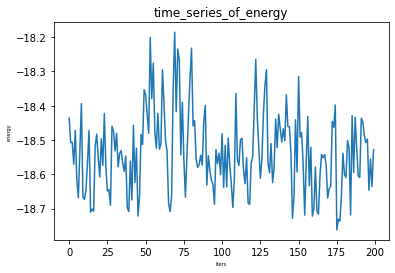

In [9]:
plt.title('time_series_of_energy')
plt.xlabel('iters', fontsize=5)
plt.ylabel('energy', fontsize=5)
plt.plot(energy_list)

In [11]:
spins_list = xy_1d.mcmc(100, show_energy=True, period=2, show_plot=True, folder_name='sampling')

Step: 1 Energy: -18.294539854088136	
Step: 2 Energy: -18.304661440862063	
Step: 3 Energy: -18.314791180765873	
Step: 4 Energy: -18.316696677627043	
Step: 5 Energy: -18.30441352878871	
Step: 6 Energy: -18.30441352878871	
Step: 7 Energy: -18.37730456098917	
Step: 8 Energy: -18.393376605162278	
Step: 9 Energy: -18.445037408960534	
Step: 10 Energy: -18.445037408960534	
Step: 11 Energy: -18.444440987432365	
Step: 12 Energy: -18.44600674865574	
Step: 13 Energy: -18.444433334434905	
Step: 14 Energy: -18.43892715829811	
Step: 15 Energy: -18.439154672030135	
Step: 16 Energy: -18.44118904108699	
Step: 17 Energy: -18.448017787790775	
Step: 18 Energy: -18.448017787790775	
Step: 19 Energy: -18.46018078368822	
Step: 20 Energy: -18.468355073520005	
Step: 21 Energy: -18.470830923700483	
Step: 22 Energy: -18.467637030739038	
Step: 23 Energy: -18.504515904791468	
Step: 24 Energy: -18.504515904791468	
Step: 25 Energy: -18.491288647677393	
Step: 26 Energy: -18.491288647677393	
Step: 27 Energy: -18.4940445

-----
### Non-periodic boundary condition

In [12]:
# initialize the 1d xy model
length = 20
xy_1d = XY_1D(length, beta=20, j=1, periodic_cond=False)

In [13]:
# firing stage
spins_list = xy_1d.mcmc(3000, show_energy=False, store_period=40, folder_name='firing')
print('mcmc is done!')

mcmc is done!


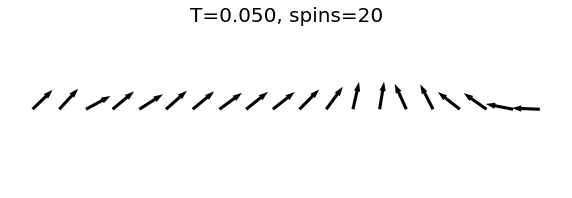

In [14]:
xy_1d.spin_viz_dynamic(spins_list, file_name='./mcmc_dynamics', figsize=[10, 3])

In [15]:
### sampling stage
energy_list = []
for i in trange(200):
    energy_list.append(xy_1d.mcmc(200, show_energy=False, show_plot=False, energy_accumu=True)[0])
print("iterations are done!")

  0%|          | 0/200 [00:00<?, ?it/s]

iterations are done!


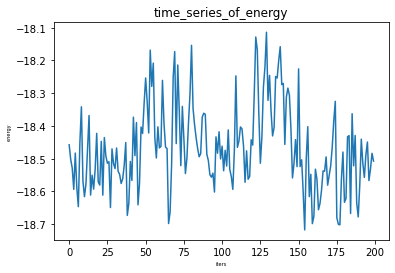

In [16]:
plt.title('time_series_of_energy')
plt.xlabel('iters', fontsize=5)
plt.ylabel('energy', fontsize=5)
plt.plot(energy_list)

In [17]:
spins_list = xy_1d.mcmc(100, show_energy=True, period=2, show_plot=True, folder_name='sampling')

Step: 1 Energy: -18.42388235217096	
Step: 2 Energy: -18.42318185030433	
Step: 3 Energy: -18.446551660479063	
Step: 4 Energy: -18.449439430686194	
Step: 5 Energy: -18.455414098378967	
Step: 6 Energy: -18.43640158456734	
Step: 7 Energy: -18.451874280156716	
Step: 8 Energy: -18.47550921201508	
Step: 9 Energy: -18.472675338353262	
Step: 10 Energy: -18.46506977930941	
Step: 11 Energy: -18.47123435287993	
Step: 12 Energy: -18.475765267264197	
Step: 13 Energy: -18.44964189989132	
Step: 14 Energy: -18.44800055715852	
Step: 15 Energy: -18.428788417709637	
Step: 16 Energy: -18.376663853460755	
Step: 17 Energy: -18.365963586355917	
Step: 18 Energy: -18.365869437145445	
Step: 19 Energy: -18.370155837252064	
Step: 20 Energy: -18.359852756771684	
Step: 21 Energy: -18.363529357953436	
Step: 22 Energy: -18.354302681551346	
Step: 23 Energy: -18.354706353481948	
Step: 24 Energy: -18.36099130065871	
Step: 25 Energy: -18.36099130065871	
Step: 26 Energy: -18.3626648423049	
Step: 27 Energy: -18.391663791612